In [25]:
import sys
import numpy as np
import import_ipynb
from scipy.sparse.linalg import spsolve
from pathlib import Path
from IPython.display import SVG, display

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps  
    from fem_pre_processing import read_mesh
    from fem_processing import matrices_assembly 
    from fem_pos_processing import graph_results
    print("Modules imports were successful!")
except ModuleNotFoundError as en:
    print(f"Modules were not found: {en}")
except ImportError as en:
    print(f"Error in import: {en}")
    
#run ../setup_project.py

Project root added to sys.path: C:\Users\adilt\OneDrive\01_ACADEMIA\06 MODELOS\8.FEM\ppgee\projects
Modules imports were successful!


# Project 4: Vectorial Poisson Problem at Rectangular Domain $\Omega = [-1,1]^2$

Considere um problema vetorial de _Poisson_ 2D em $\Omega = [-1,1]^2$

$$
\nabla \times \nabla \times \mathbf{u}(\mathbf{x}) + a \mathbf{u}(\mathbf{x}) =
\mathbf{f}(\mathbf{x}) \quad \text{em} \; \Omega = [-1, 1]^2
\tag{1}
$$

$$
\hat{n} \times \mathbf{u} = 0 \quad \text{em} \; \partial \Omega
$$

onde a fonte é dada por,
$$
\mathbf{f}(x,y) = (2\pi^2 + 1)\, 
\begin{pmatrix}
cos(\pi x)  sin(\pi x) \\
-sin(\pi x)  cos(\pi y) \\
\end{pmatrix}
\tag{2}
$$

A solução analítica deste problema é

$$
\mathbf{u}(x,y) = 
\begin{pmatrix}
cos(\pi x)  sin(\pi x) \\
-sin(\pi x)  cos(\pi y) \\
\end{pmatrix}
\tag{3}
$$

Implemente um programa de elementos finitos utilizando elementos de _Nedelec_ do tipo 1, $N_0$, em $R^2$ para resolver o Problema de Valor de Contorno vetorial $(1)$.

# 3-noded Linear Triangular Elements, $P_1$
## Pre-processor module
## Geometry and mesh Domain

In [26]:
FINITE_ELEMENT = ("Triangle", 1)
BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': 0.0, 'name': 'entire_boundary'}]
MATERIAL = [{'tag': 201, 'name': 'free_space', 'a_constant': 1}]

# Create mesh from file geometry
ps.create_meshed_domain(FINITE_ELEMENT, BOUNDARY, MATERIAL, h=2, view_mesh=False)

# Read mesh data
mesh_data = read_mesh.get_data(FINITE_ELEMENT, BOUNDARY, MATERIAL, model='vectorial_poisson', info_mode=False)

Model vectorial_poisson_domain_Triangle1 (2D)
Info     : 9 geometric entities
Info     : 2 Physical Groups
Info     : 5 nodes in total
Info     : 4 2-D elements in total


# Figure 1: Vectorial Shape Functions

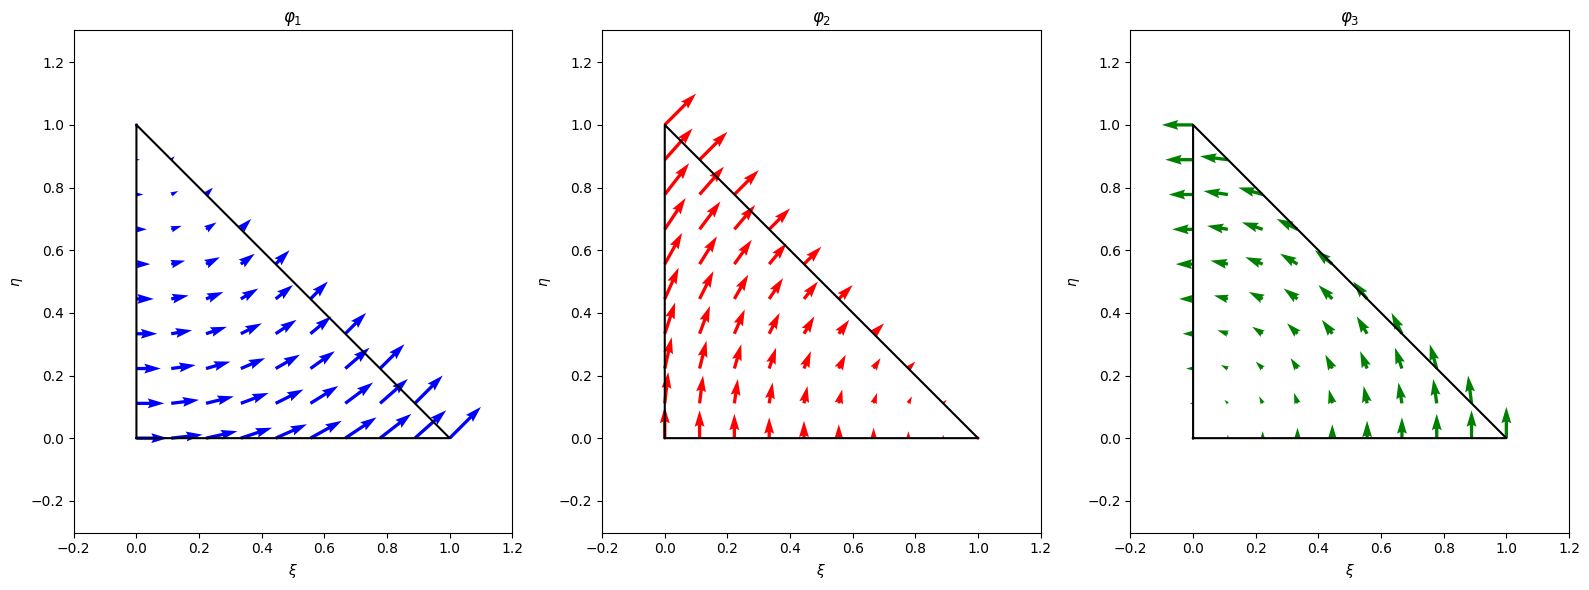

In [27]:
ps.plot_shape_functions_n0()

# Figure 2: Meshed domain

Arquivo salvo em: c:\Users\adilt\OneDrive\01_ACADEMIA\06 MODELOS\8.FEM\ppgee\projects\p41_vectorial_poisson_problem\pre_processing\pictures\meshed_domain_Triangle1_EntireDomain.svg


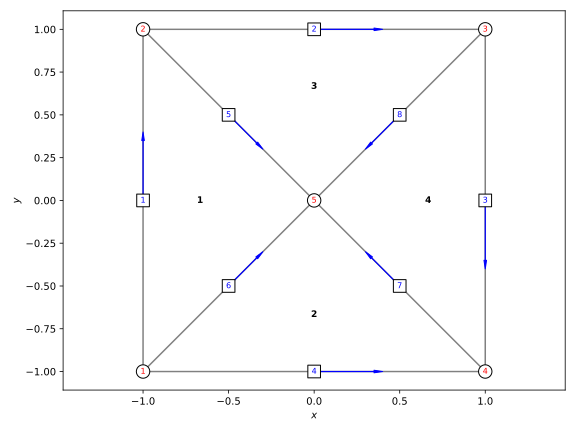

In [28]:
graph_results.plot_mesh(FINITE_ELEMENT, mesh_data, numbering=True, show_edges=True)
display(SVG(filename="pre_processing/pictures/meshed_domain_Triangle1_EntireDomain.svg"))

<!-- <figure>
    <img src="pre_processing/pictures/vectorial_poisson_meshed_domain_Triangle1.svg" alt="Fig.2" style="width:80%;" />
    <figcaption>Figure 2: Rectangular meshed domain $\Omega=[-1,1]^2$.</figcaption>
</figure> -->

# Figure 3: Shape functions Meshed domain

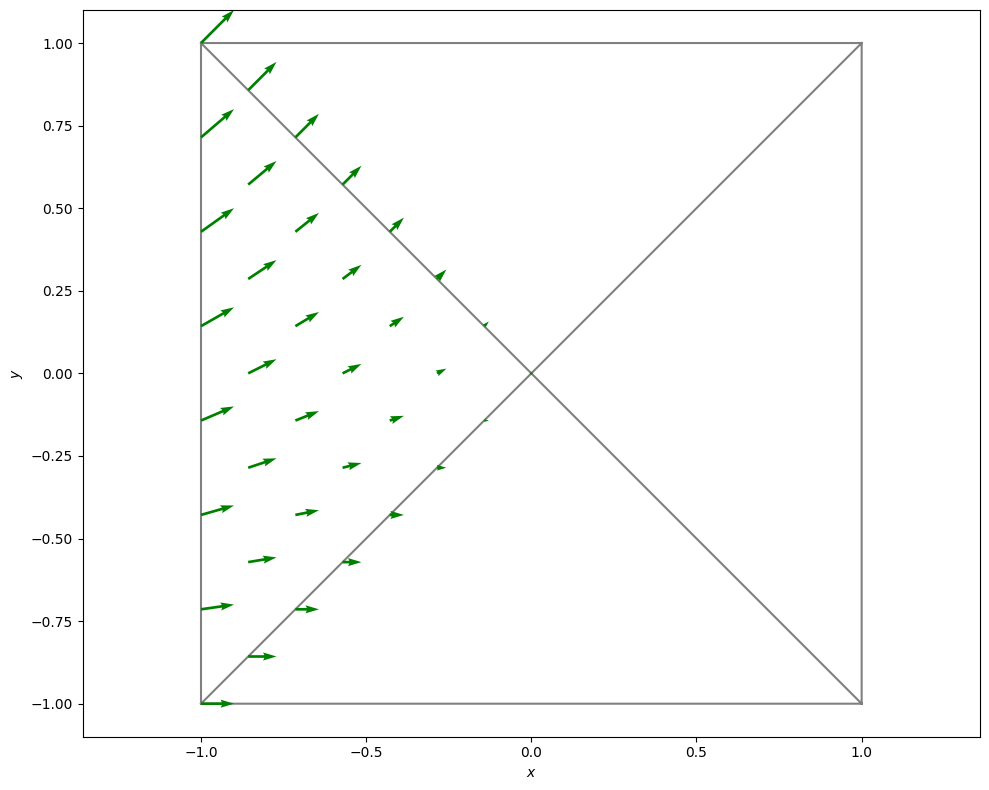

In [29]:
graph_results.plot_meshed_shape_func(FINITE_ELEMENT, mesh_data)

# `plot_analytical_solution()`

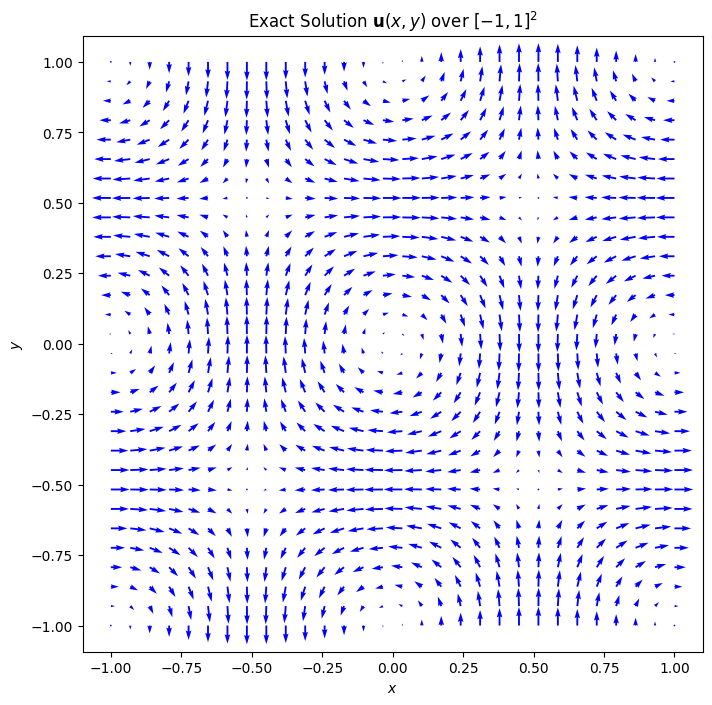

In [30]:
ps.plot_analytical_solution()

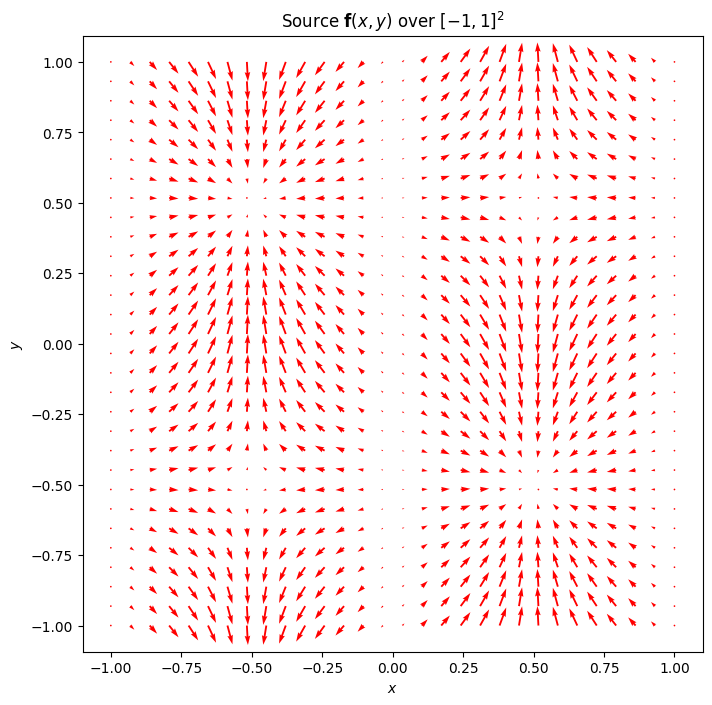

In [31]:
ps.plot_analytical_source()

## `apply_physics()`

In [32]:
mesh_data = ps.apply_physics(FINITE_ELEMENT, mesh_data)

## Data Structures

In [33]:
cell_data = mesh_data['cell']; cell_data[1]

{'conn': [1, 2, 5],
 'conn_sorted': [1, 2, 5],
 'conn_edge': [1, 5, 6],
 'contour': {'type': None, 'conn_dict': None},
 'material': {'tag': 201, 'name': 'free_space', 'a_constant': 1},
 'stiffness_term': [array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]])],
 'mass_term': [1, 1, 1, 1, 1, 1, 1],
 'source': [array([[ 8.98034095],
         [17.96068157]]),
  array([[1.93397748],
         [5.73406574]]),
  array([[1.93397748],
         [5.73406449]]),
  array([[3.80008766],
         [3.86795432]]),
  array([[ 6.16271366],
         [-3.74987967]]),
  array([[ 6.16271366],
         [-3.74988   ]]),
  array([[-9.91259313],
         [12.32542679]])],
 'abc': {'type': None, 'conn_idx': None}}

In [34]:
nodes_data = mesh_data['nodes']; nodes_data[1]

{'xg': (-1.0, -1.0),
 'bc': {'tag': 101,
  'type': 'Dirichlet',
  'value': 0.0,
  'name': 'entire_boundary'}}

In [35]:
conn_data = {key: cell['conn'] for key, cell in mesh_data['cell'].items()}; conn_data[1]

[1, 2, 5]

In [36]:
edges_data = mesh_data['edges']; edges_data[1]

[1, 2]

## ``global_nodes_coordinates()``

In [37]:
nodes_coord = {key: value['xg'] for key, value in nodes_data.items()}; nodes_coord[1]

(-1.0, -1.0)

## $x_g, y_g$ global coordinate

In [38]:
{key: value['xg'][0] for key, value in nodes_data.items()}

{1: -1.0, 2: -1.0, 3: 1.0, 4: 1.0, 5: 0.0}

In [39]:
{key: value['xg'][1] for key, value in nodes_data.items()}

{1: -1.0, 2: 1.0, 3: 1.0, 4: -1.0, 5: 0.0}

## $a_e = (x_e, y_e)$ global element coordinate

In [40]:
ai = {key: [nodes_data[id]['xg'] for id in node_ids] for key, node_ids in conn_data.items()}
print("'a_e' global coordinates: "); ai

'a_e' global coordinates: 


{1: [(-1.0, -1.0), (-1.0, 1.0), (0.0, 0.0)],
 2: [(1.0, -1.0), (-1.0, -1.0), (0.0, 0.0)],
 3: [(-1.0, 1.0), (1.0, 1.0), (0.0, 0.0)],
 4: [(1.0, 1.0), (1.0, -1.0), (0.0, 0.0)]}

In [41]:
print("'a_1' global coordinates: "); ai[1]

'a_1' global coordinates: 


[(-1.0, -1.0), (-1.0, 1.0), (0.0, 0.0)]

In [42]:
print("'Node 2' global coordinates: "); nodes_data[2]['xg']

'Node 2' global coordinates: 


(-1.0, 1.0)

In [43]:
xi = {key: [coord[0] for coord in coords] for key, coords in ai.items()}
print("'x_1' x-coordinates: "); xi[1]

'x_1' x-coordinates: 


[-1.0, -1.0, 0.0]

## `map_to_physical_coordinates()`

In [44]:
xi_master = (0, 1)
xg_1, yg_1 = matrices_assembly.isomapping_to_global_coordinates(FINITE_ELEMENT, ai[1], xi_master)
print(f"'e_1' Master coordinates: {xi_master} --> Global coordinates: ({xg_1}, {yg_1})")

'e_1' Master coordinates: (0, 1) --> Global coordinates: (0.0, 0.0)


## Material Proprieties, $k_a$

In [45]:
ka = {key: cell['stiffness_term'] for key, cell in cell_data.items()}
# Imprimir cada chave em uma linha
for key, matrices in ka.items():
    print(f"{key}: { [matrix.tolist() for matrix in matrices] }")

1: [[[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]]]
2: [[[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]]]
3: [[[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]]]
4: [[[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]]]


## Source: Analytical source, $f(x)$

In [46]:
fx = {key: cell['source'] for key, cell in cell_data.items()}
# Imprimir cada chave em uma linha
for key, matrices in fx.items():
    print(f"{key}: { [matrix.tolist() for matrix in matrices] }")

1: [[[8.980340947128544], [17.960681568486354]], [[1.933977479226366], [5.734065740777936]], [[1.9339774792263613], [5.734064494453193]], [[3.800087655336428], [3.8679543183431413]], [[6.162713657490409], [-3.7498796653490287]], [[6.162713657490409], [-3.7498799980505506]], [[-9.912593131545687], [12.325426790985546]]]
2: [[[6.515414634157329e-07], [3.2577073761669394e-07]], [[-5.532847212733659], [-1.866110782325204]], [[5.532846110638567], [1.8661108162196482]], [[6.515414670325144e-07], [6.401095985204436e-07]], [[-9.781481034173133], [16.07530698032984]], [[9.781481466779816], [-16.075306265040822]], [[-6.515414561821696e-07], [5.239952719683655e-07]]]
3: [[[-6.515414634157329e-07], [-3.2577073761669394e-07]], [[5.532847212733659], [1.866110782325204]], [[-5.532846110638567], [-1.8661108162196482]], [[-6.515414670325144e-07], [-6.401095985204436e-07]], [[9.781481034173133], [-16.07530698032984]], [[-9.781481466779816], [16.075306265040822]], [[6.515414561821696e-07], [-5.2399527196

## Jacobian Matrix Transform

In [47]:
Je = matrices_assembly.jacobian(FINITE_ELEMENT, mesh_data, cell_data[1], xik=(0, 0)) 
Jdet, Jinv = np.abs(np.linalg.det(Je)), np.linalg.inv(Je)
print("Jacobian matrix for element e_1:\n", Je)
print("Determinant of the Jacobian matrix for element e_1:", Jdet)

Jacobian matrix for element e_1:
 [[0. 2.]
 [1. 1.]]
Determinant of the Jacobian matrix for element e_1: 2.0


## Local Elements $e_1$

In [48]:
Ae, fe, Me, Pe, Qe  = matrices_assembly.local_matrices(FINITE_ELEMENT, mesh_data, cell_data[1])
print("Local stiffness matrix for element e_1:\n", Ae)
print("Local load vector for element e_1:\n", fe)

ValueError: operands could not be broadcast together with shapes (3,1) (2,1) 

## Global “stiffness” matrix, $A_g$

In [ ]:
Ag, fg, Mg, Pg, Qg = matrices_assembly.global_matrices(FINITE_ELEMENT, mesh_data)
print("Global matrix shape:", Ag.shape)

## Imposition of Boundary Conditions
### $Dirichlet$ nodes

In [ ]:
dirichlet_nodes = {key: value 
                   for key, value in nodes_data.items() if value['bc']['type'] == 'Dirichlet'}
dirichlet_nodes

In [ ]:
Nn = len(nodes_data); Nd = len(dirichlet_nodes)
print(f"The entire domain has {Nn} nodes: {Nn - Nd} free nodes; {Nd} Dirichlet nodes.")

In [ ]:
free_nodes = {key: value for key, value in nodes_data.items() if value['bc']['type'] != 'Dirichlet'}; free_nodes

## Mapping Global nodes to reduced system

This code creates a dictionary called ``global_to_reduced``, which maps the global indices of the mesh nodes to the reduced indices, i.e. the indices that correspond only to the nodes that are not in the _Dirichlet boundary conditions_.

In [ ]:
{global_id: idx + 1 for idx, global_id in enumerate(free_nodes.keys())}

## Processor Module
## Asymmetric Global matrix $A_g$ with boundary conditions

In [ ]:
Ag, fg = boundary_conditions.apply_simple_dirichlet(Ag, fg, mesh_data)
print("Global matrix shape:", Ag.shape)

## Global Potential Vector

In [ ]:
# Make sure Ag is in CSR format for efficiency
# Convert fg to a dense format or keep it sparse as needed
# Solve the linear system Ag * u = fg
ug = spsolve(Ag.tocsr(), fg.toarray())
print("The solution vector u is: \n", ug)

## Reduced Global matrix $A_{gr}$ with boundary conditions

In [ ]:
Agr, fgr, Mgr, Pgr, Qgr = boundary_conditions.reduced_global_matrices(FINITE_ELEMENT, mesh_data)
print("Reduced global matrix shape:", Agr.shape)

## Global Potential Solution

In [ ]:
ur = spsolve(Agr.tocsr(), fgr.toarray())
potential_u = boundary_conditions.global_potentials_solution(mesh_data, ur)
print("Reduced solution vector ur: ", ur)
print("Global potential vector V: "); potential_u

## Solution at each element

In [ ]:
u_for_cell = {}
for en, cell in mesh_data['cell'].items():
    u_e = []
    for node in cell['conn']:
        u_e.append(potential_u[node])
    u_for_cell[en] = u_e

print("The complete solution for each cell."); u_for_cell

## Interpolate Solution at element, $e_n$

In [ ]:
xi_master = (0, 0.5)
en = 1
u_at_node = matrices_assembly.isomapping_to_global_coordinates(u_for_cell[en], xi_master, FINITE_ELEMENT)

print(f"Element e_{en}: Potential 'u' interpolate at xi = {xi_master} --> u(xi): {u_at_node}")

## Post-Processor

In [ ]:
graph_results.fem_solution(FINITE_ELEMENT, mesh_data, potential_u, type='abs')

Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2024.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.